In [127]:
cd "C:\Users\jmich\OneDrive\Repository\Databases"

C:\Users\jmich\OneDrive\Repository\Databases


### Blight Analysis 

##### Analysis Objective: 

The Michigan Data Science Team (MDST) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (MSSISS) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. In this notebook I will attempt to predict whether a given blight ticket will be paid on time.

All data for in this notebook has been provided to us through the Detroit Open Data Portal.

In [150]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , roc_auc_score,accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [129]:
#import the data 
data = pd.read_csv('blight_train.csv',encoding = "ISO-8859-1")
address = pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Data Cleanup

In [130]:
# Join address.csv to latlon.cvs to add latitude and longitute to each address, and ticket # 
print(address.head(), '\n\n' , latlons.head(), '\n\n')

full_loc = address.set_index('address').join(latlons.set_index('address'), how='left').dropna().reset_index(drop=False)

print(full_loc.head(),'\n\n')
print(full_loc.info())

   ticket_id                      address
0      22056       2900 tyler, Detroit MI
1      27586     4311 central, Detroit MI
2      22062  1449 longfellow, Detroit MI
3      22084  1441 longfellow, Detroit MI
4      22093   2449 churchill, Detroit MI 

                                   address        lat        lon
0  4300 rosa parks blvd, Detroit MI 48208  42.346169 -83.079962
1                14512 sussex, Detroit MI  42.394657 -83.194265
2                3456 garland, Detroit MI  42.373779 -82.986228
3                5787 wayburn, Detroit MI  42.403342 -82.957805
4              5766 haverhill, Detroit MI  42.407255 -82.946295 


                      address  ticket_id        lat        lon
0  -11064 gratiot, Detroit MI     328722  42.406935 -82.995599
1  -11871 wilfred, Detroit MI     350971  42.411288 -82.993674
2   -15126 harper, Detroit MI     344821  42.406402 -82.957525
3       0 10th st, Detroit MI      24928  42.325689 -83.064330
4       0 10th st, Detroit MI      71887  4

In [131]:
# data
print("shape of dataset (#row, #columns)", data.shape) 
print("features:", data.columns)
data.head()

shape of dataset (#row, #columns) (250306, 34)
features: Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [132]:
# adding address detials to training and testing set using ticket_id 
data=pd.merge(data, full_loc, on='ticket_id').set_index('ticket_id')

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250303 entries, 22056 to 325561
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   agency_name                 250303 non-null  object 
 1   inspector_name              250303 non-null  object 
 2   violator_name               250269 non-null  object 
 3   violation_street_number     250303 non-null  float64
 4   violation_street_name       250303 non-null  object 
 5   violation_zip_code          0 non-null       float64
 6   mailing_address_str_number  246701 non-null  float64
 7   mailing_address_str_name    250299 non-null  object 
 8   city                        250303 non-null  object 
 9   state                       250210 non-null  object 
 10  zip_code                    250302 non-null  object 
 11  non_us_str_code             3 non-null       object 
 12  country                     250303 non-null  object 
 13  ticket_iss

In [134]:
data[['state','city']].value_counts()

state  city           
MI     DETROIT            136506
       SOUTHFIELD          13395
       Detroit             10445
       detroit              4165
       DEARBORN             3622
                           ...  
       Farminigton Mi          1
       Farminton Hills         1
       Fenon                   1
       Ferdale                 1
WY     EVANSVILLE              1
Length: 6141, dtype: int64

Data is not clean. Will need to convert data types and do some conversions on str values 

In [135]:
# converts all 'objects' to upper case 
data = data.apply(lambda x: x.astype(str).str.upper() if(x.dtype == 'object') else x)

convert_dict = {
    'agency_name':'category',
    'violation_street_name':'category',
    'city': 'category',
    'state':'category',
    'violation_code':'category',
    'disposition':'category',
}

data = data.astype(convert_dict)

data = data[(data['city'] == 'DETROIT') & (data['state'] == 'MI')]

data[['state','city']].value_counts()

state  city   
MI     DETROIT    151122
dtype: int64

### EDA 

##### General compliance infomation 

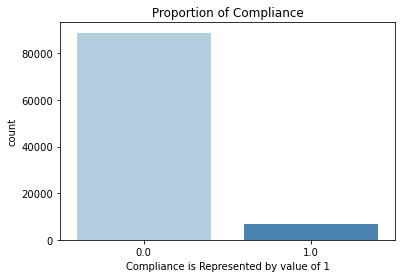

In [136]:
sns.countplot( x= data.compliance, palette = "Blues")
plt.title("Proportion of Compliance")
plt.xlabel('Compliance is Represented by value of 1')
plt.show()

In [137]:
# $$$$ amounts resulting from blight
total_fines = data['judgment_amount'].sum()
uncollected_fines = data['payment_amount'].sum()

print(f"Total Fines issued in City of Detriot: ", "${:,.2f}".format(total_fines))
print("Uncollected Fines: ", "${:,.2f}".format(uncollected_fines))
print(f"Percent of Fines Uncollected: {uncollected_fines/total_fines * 100:.2f}%")

Total Fines issued in City of Detriot:  $36,808,536.50
Uncollected Fines:  $5,853,014.60
Percent of Fines Uncollected: 15.90%


In [138]:
# top reasons for tickets 
data['violation_description'].str.lower().value_counts().head(7)

failure of owner to obtain certificate of compliance                                                    62803
failure to obtain certificate of registration for rental property                                       25921
failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste    15362
excessive weeds or plant growth one- or two-family dwelling or commercial building                      11906
violation of time limit for approved containers to remain at curbside - early or late                    3728
allowing bulk solid waste to lie or accumulate on or about the premises                                  3487
inoperable motor vehicle(s) one- or two-family dwelling or commercial building                           3481
Name: violation_description, dtype: int64

In [139]:
# Top agencies issuing tickets
print(data['agency_name'].value_counts()) 
print('\n Total tickets issued: ', '{:,}'.format(len(data)))

BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT    97284
DEPARTMENT OF PUBLIC WORKS                        41025
DETROIT POLICE DEPARTMENT                          7044
HEALTH DEPARTMENT                                  5769
NEIGHBORHOOD CITY HALLS                               0
Name: agency_name, dtype: int64

 Total tickets issued:  151,122


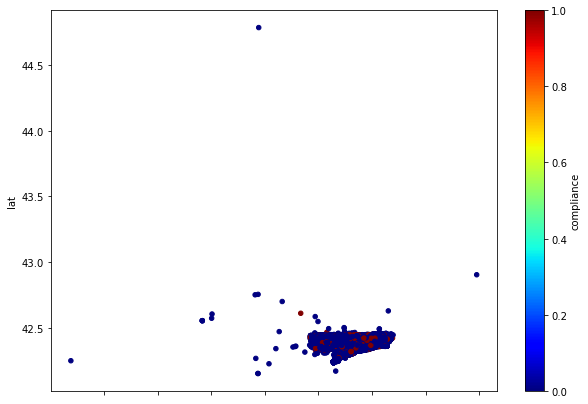

In [140]:
# checking to see if compliance is geographically dispersed
data.plot(kind = 'scatter', x = 'lon', y = 'lat', c = "compliance", figsize = (10,7), cmap = plt.get_cmap("jet"))
plt.show()

#### Final data processing

In [143]:
# limiting dataset to simplify models and avoid data leakage
modeling_columns = ['violation_street_number', 'agency_name', 
        'fine_amount', 'late_fee', 'discount_amount', 'judgment_amount', 'lat', 'lon', 'compliance']

data = data[modeling_columns]
data = data.dropna()

#convert categories to integers 
cat_columns = data.select_dtypes(['category']).columns
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)

#scaling 
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

#split the data into test and training sets
train, test = train_test_split(data, random_state = 42)
X_train = train.drop(columns = 'compliance')
y_train = train['compliance']
X_test = test.drop(columns = 'compliance')
y_test = test['compliance']

#### Modeling 

In [ ]:
def print_model_scores(clf, data, y_train, X_test, y_test, train = True):
    if train:
        pred = clf.predict(data)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

##### Gradient Boosting Classifier 

Best params: {'learning_rate': 0.1}
0.7829188801131208
Train Result:
Accuracy Score: 93.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision      0.937003     0.934650  0.936981      0.935827      0.936836
recall         0.999355     0.120707  0.936981      0.560031      0.936981
f1-score       0.967175     0.213801  0.936981      0.590488      0.913694
support    66677.000000  5095.000000  0.936981  71772.000000  71772.000000
_______________________________________________
Confusion Matrix: 
 [[66634    43]
 [ 4480   615]]

Test Result:
Accuracy Score: 93.61%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision      0.936283     0.921488  0.936134      0.928886      0.935212
recall         0.999144     0.128753  0.936134      0.563948      0.936134
f1-score       0.966693     0.

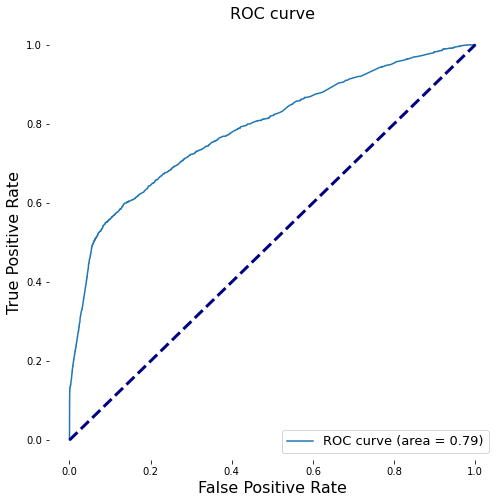

In [157]:
param_grid = {'learning_rate': [0.01, 0.1, 1]}

clf = GradientBoostingClassifier(random_state = 42)

grid = GridSearchCV(clf, param_grid, scoring = 'roc_auc')
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(f"Best params: {best_params}")
print(grid.best_score_)

clf = GradientBoostingClassifier(**best_params)
clf.fit(X_train, y_train)
print_model_scores(clf, X_train, y_train, X_test, y_test, train=True)
print_model_scores(clf, X_train, y_train, X_test, y_test, train=False)

y_score_lr = clf.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8,8))

plt.plot(fpr_lr, tpr_lr, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
sns.despine(top=True, bottom=True, left=True)

Train Result:
Accuracy Score: 93.30%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision      0.933200     0.890411  0.932982      0.911805      0.930162
recall         0.999400     0.063788  0.932982      0.531594      0.932982
f1-score       0.965166     0.119048  0.932982      0.542107      0.905101
support    66677.000000  5095.000000  0.932982  71772.000000  71772.000000
_______________________________________________
Confusion Matrix: 
 [[66637    40]
 [ 4770   325]]

Test Result:
Accuracy Score: 93.27%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision      0.932834     0.912162  0.932706      0.922498      0.931338
recall         0.999414     0.077945  0.932706      0.538679      0.932706
f1-score       0.964977     0.143617  0.932706      0.554297      0.905517
support   

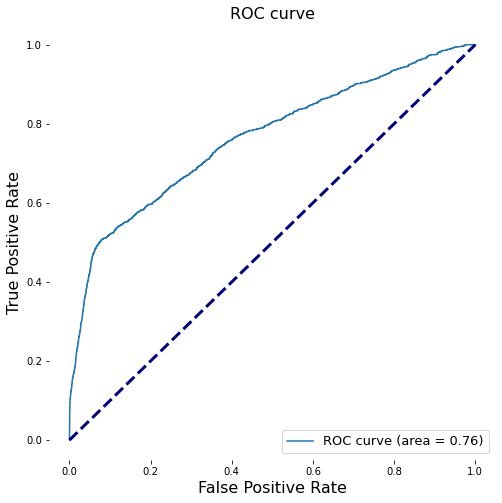

In [156]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train,y_train)

print_model_scores(clf, X_train, y_train, X_test, y_test, train=True)
print_model_scores(clf, X_train, y_train, X_test, y_test, train=False)

y_score_lr = clf.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8,8))

plt.plot(fpr_lr, tpr_lr, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
sns.despine(top=True, bottom=True, left=True)

Final notes. Both models have great results. Feature engineering can futher improve these models. I think that my next steps would be to develop a feature to represent the days from ticket issue to hearing date. I would also invest further which features have the greatest effect on the model. 